In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import tv_model, ResBam
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import LoadImage, AsTensor, Transpose
import cosmosis.dataset as dataset

from dataset import Ranzcr
from learning import RSelector

from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

from IPython.display import display


In [ ]:
ds_params={'embed': [],
            'image_dir': './data/ranzcr/train',
            'target_csv': './data/ranzcr/train.csv',
            'target_type': 'ETT',
            'transform': transforms.Compose([LoadImage(),
                                             transforms.Resize(224),
                                             ]),
            'target_transform': None}

ds = Ranzcr(**ds_params)
ids = dataset.ImageDatasetStats()

for i in ds.ds_idx:
    ids(ds[i][0])
    
print(ids.stats.mean) #123.2/255=.483
print(ids.stats.stddev) #59.4/255=.233

CDataset created...
CDataset created...
CDataset created...
CModel loaded...
ResBam model loaded...
learning time: 0:07:26.632443
epoch: 0, lr: 0.01
train loss: 0.7333431758756515, val loss: 0.6427942424589861
sk_train_log: 0.6731117277601621, sk_val_log: 0.726916353703422
learning time: 0:14:53.581443
epoch: 1, lr: 0.01
train loss: 0.6229325811234289, val loss: 0.6709208755839801
sk_train_log: 0.7391621167819864, sk_val_log: 0.7864900459146871
learning time: 0:22:22.115883
epoch: 2, lr: 0.01
train loss: 0.6103777644482065, val loss: 0.5883676381187236
sk_train_log: 0.751449100138444, sk_val_log: 0.8089644198969661
learning time: 0:29:51.035536
epoch: 3, lr: 0.01
train loss: 0.5984509615708811, val loss: 0.5616229447067207
sk_train_log: 0.7766682286981411, sk_val_log: 0.7980523045220738
learning time: 0:37:18.179690
epoch: 4, lr: 0.01
train loss: 0.5802386935041668, val loss: 0.5390101399616147
sk_train_log: 0.77561928074842, sk_val_log: 0.8156743670645554
learning time: 0:44:45.730097

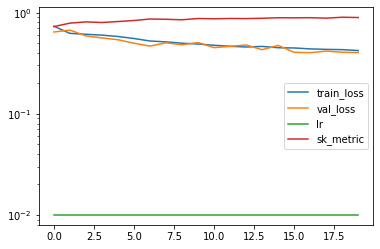

In [2]:
ds_params={'train_params': {'embed': [],
                            'image_dir': './data/ranzcr/train',
                            'target_csv': './data/ranzcr/train.csv',
                            'target_type': 'ETT',
                            'transform': transforms.Compose([LoadImage(),
                                                             transforms.Resize(1000),
                                                             transforms.RandomRotation(10),
                                                             transforms.CenterCrop(800),
                                                             transforms.RandomCrop(512),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize(.483,.233),
                                                             ]),
                            'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])},
           'val_params': {'embed': [],
                          'image_dir': './data/ranzcr/train',
                          'target_csv': './data/ranzcr/train.csv',
                          'target_type': 'ETT',
                          'transform': transforms.Compose([LoadImage(),
                                                           transforms.Resize(1000),
                                                           transforms.CenterCrop(512),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(.483,.233),
                                                           ]),
                          'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])},
           'test_params': {'embed': [],
                           'image_dir': './data/ranzcr/train',
                           'target_csv': './data/ranzcr/train.csv',
                           'target_type': 'ETT',
                           'transform': transforms.Compose([LoadImage(),
                                                            transforms.Resize(1000),
                                                            transforms.CenterCrop(512),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(.483,.233),
                                                            ]),
                          'target_transform': transforms.Compose([
                                                       dataset.AsTensor(),
                                                       dataset.Squeeze()])}}

model_params = {'n_classes': 4,
                'residuals': True,
                'in_channels': 1,
                'groups': 1,
                'bam': True}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}
    
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

#RSelector balances classes (target_type) of the Ranzcr ds
#sample_params = {'set_seed': False,
#                 'splits': (.7,.15),
#                 'target_type': 'ETT',
#                 'subset': False}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': False}

sched_params = {'factor': .5,
                'patience': 4,
                'cooldown': 2}

learn = Learn([Ranzcr,Ranzcr,Ranzcr], 
              ResBam, 
              Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss, 
              model_params=model_params, ds_params=ds_params, sample_params=sample_params,
              opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
              metrics_params=metrics_params,
              adapt=False, load_model=False, load_embed=False, save_model=False,
              batch_size=16, epochs=20)